In [215]:
# Import necessary libraries 
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from sklearn.preprocessing import LabelEncoder
import spacy
import string
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import warnings
warnings.filterwarnings('ignore')

from keras.optimizers import Adam
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Conv1D,Dense,Embedding,MaxPooling1D,GlobalMaxPooling1D,Input
from keras.models import Model,Sequential
from sklearn.metrics import roc_auc_score
from wordcloud import WordCloud
import tensorflow as tf

In [216]:
nltk.download("stopwords") #download nltk 

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ahame\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [287]:
# Import the dataset as csv using pandas and remove unwanted columns
dataset= pd.read_csv("./data/sms_spam_ham.csv",encoding='latin-1') 
dataset.drop(columns=[
    'Unnamed: 2',
    'Unnamed: 3',
    'Unnamed: 4',
] , inplace=True)
dataset.head(20)

,label,review
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
5,spam,FreeMsg Hey there darling it's been 3 week's n...
6,ham,Even my brother is not like to speak with me. ...
7,ham,As per your request 'Melle Melle (Oru Minnamin...
8,spam,WINNER!! As a valued network customer you have...
9,spam,Had your mobile 11 months or more? U R entitle...


In [218]:
dataset.describe()

,label,review
count,5572,5572
unique,2,5169
top,ham,"Sorry, I'll call later"
freq,4825,30


In [219]:
dataset.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5572 non-null   object
 1   review  5572 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


In [220]:
dataset.groupby('label').describe()

review                                                               
       count unique                                                top freq
label                                                                      
ham     4825   4516                             Sorry, I'll call later   30
spam     747    653  Please call our customer service representativ...    4

In [221]:
dataset['length'] = dataset['review'].apply(len) # add a length column for get the length of each review texts

In [222]:
dataset.head()

,label,review,length
0,ham,"Go until jurong point, crazy.. Available only ...",111
1,ham,Ok lar... Joking wif u oni...,29
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,155
3,ham,U dun say so early hor... U c already then say...,49
4,ham,"Nah I don't think he goes to usf, he lives aro...",61


In [223]:
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [224]:
label_encoder = LabelEncoder()

In [225]:
dataset['label'] = label_encoder.fit_transform(dataset['label']) # add Label encoding to target column 

In [226]:
dataset['label']

0       0
1       0
2       1
3       0
4       0
       ..
5567    1
5568    0
5569    0
5570    0
5571    0
Name: label, Length: 5572, dtype: int32

In [227]:
## Correlation
dataset.corr()

,label,length
label,1.000000,0.387285
length,0.387285,1.000000


## Data Visualization

<Axes: ylabel='Frequency'>

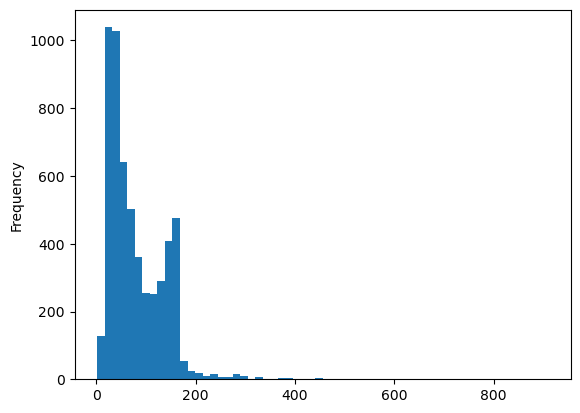

In [228]:
dataset['length'].plot.hist(bins=60)

In [229]:
dataset['length'].describe()

count    5572.000000
mean       80.118808
std        59.690841
min         2.000000
25%        36.000000
50%        61.000000
75%       121.000000
max       910.000000
Name: length, dtype: float64

array([<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
      dtype=object)

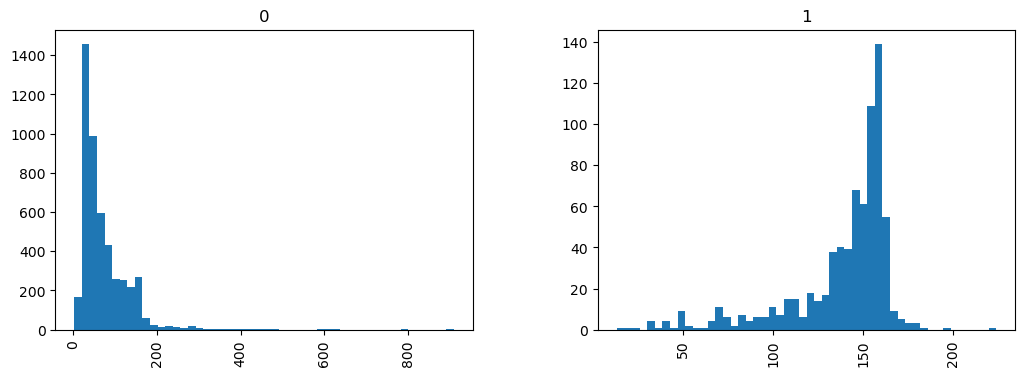

In [230]:
dataset.hist(column='length',by='label',bins=50,figsize=(12,4))

<Axes: xlabel='label', ylabel='length'>

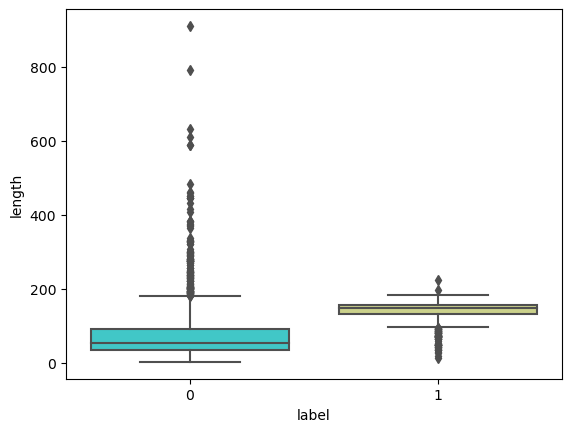

In [231]:
sns.boxplot(x='label',y='length',data=dataset,palette='rainbow')

<Axes: xlabel='label', ylabel='count'>

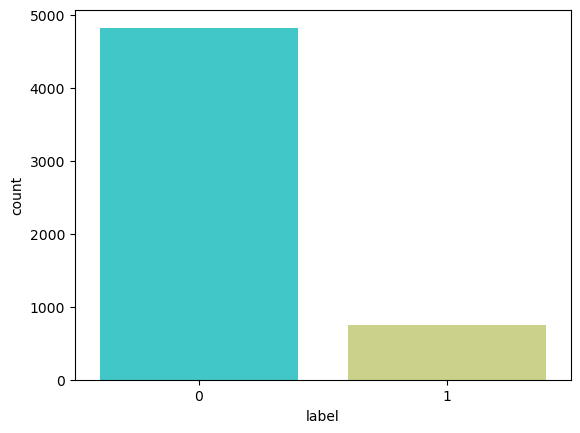

In [232]:
sns.countplot(x='label',data=dataset,palette='rainbow')

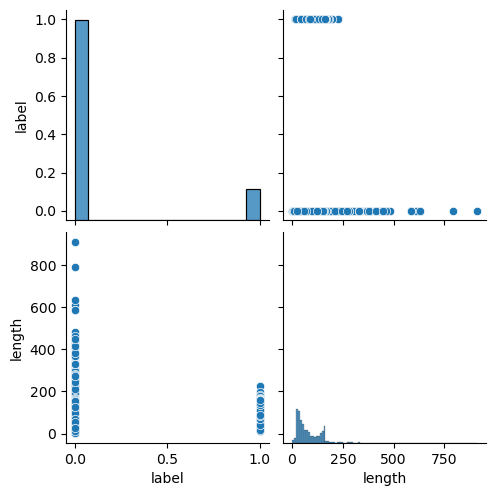

In [233]:
sns.pairplot(dataset)

## Data Cleaning

In [234]:
# Checking for NaN values
dataset.isnull().sum()

label     0
review    0
length    0
dtype: int64

In [235]:
# Checking for empty whitespace strings and assign for an array 
empty_list = []  

for i,label,review,length in dataset.itertuples():  # iterate over the DataFrame
    if type(review)==str:           
        if review.isspace():         
            empty_list.append(i)    
        
len(empty_list)

0

In [236]:
#droping NaN values
dataset.dropna(inplace=True)

In [237]:
#drop empty space values in review 
dataset.drop(empty_list,inplace=True)

In [238]:
# Checking for duplicate values
dataset.duplicated().sum()

403

In [239]:
#remove duplicate entries
dataset.drop_duplicates(keep='first',inplace=True)

In [240]:
#identify the important punctuations
string.punctuation

'!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [241]:
#load english vocabulary
nlp_load = spacy.load("en_core_web_sm")


In [242]:
nlp_load.max_length = 200000

In [243]:
#Create a function to identify the punctuations in each words
def separate_puncuation(doc_text):
    return [token for token in nlp_load(doc_text) if token.text not in '\n\n \n\n\n!"-#$%&()--.*+,-/:;<=>?@[\\]^_`{|}~\t\n ']


In [244]:
#check wheter there are any single puncuations and convert the row to string
def remove_punctuation_and_convert_to_string(token):
    return ''.join(char for char in str(token) if char not in string.punctuation)

In [245]:
#remove stopwords from each row
def remove_stop(token):
    return [word for word in token.split() if word.lower() not in stopwords.words('english')]

In [246]:
#convert each tokens to string after removing stopwords
def join_list_to_string(lst):
    return ' '.join(lst)

In [247]:
dataset['review'] = dataset['review'].apply(separate_puncuation)

In [248]:
dataset['review'] = dataset['review'].apply(remove_punctuation_and_convert_to_string)

In [249]:
dataset['review'] = dataset['review'].apply(remove_stop)

In [250]:
dataset['review'] = dataset['review'].apply(lambda x: join_list_to_string(x))

In [251]:
dataset['review'] 

0       Go jurong point crazy Available bugis n great ...
1                                 Ok lar Joking wif u oni
2       Free entry 2 wkly comp win FA Cup final tkts 2...
3                     U dun say early hor U c already say
4               Nah nt think goes usf lives around though
                              ...                        
5567    2nd time tried 2 contact u U å£750 Pound prize...
5568                          Ì b going esplanade fr home
5569                                Pity mood suggestions
5570    guy bitching acted like interested buying some...
5571                                       Rofl true name
Name: review, Length: 5169, dtype: object

In [252]:
#get the values of target data from dataset
target = dataset['label'].values

In [253]:
#get the values of taining data from dataset
train =dataset['review'].values

In [254]:
target.shape

(5169,)

In [255]:
# remove all puctuations (train data)
# remove all stopwords
# create a key value pair for word and vector an store 

token_response = []
word2vec={}
for text in train:
    print(text)
    tokens = separate_puncuation(text)
    for x in tokens:
        #word=x.text
        rem_punc = [single_letter for single_letter in x.text if single_letter not in string.punctuation]
        word=''.join(rem_punc)
        if word.lower() not in stopwords.words('english') :
            vec=np.asarray(x.vector,dtype='float32')
            word2vec[word]=vec
            #print(word)
    token_response.append(tokens)
  


Go jurong point crazy Available bugis n great world la e buffet Cine got amore wat
Ok lar Joking wif u oni
Free entry 2 wkly comp win FA Cup final tkts 21st May 2005 Text FA 87121 receive entry questionstd txt rateTC apply 08452810075over18
U dun say early hor U c already say
Nah nt think goes usf lives around though
FreeMsg Hey darling 3 week word back like fun still Tb ok XxX std chgs send å£150 rcv
Even brother like speak treat like aids patent
per request Melle Melle Oru Minnaminunginte Nurungu Vettam set callertune Callers Press 9 copy friends Callertune
WINNER valued network customer selected receivea å£900 prize reward claim call 09061701461 Claim code KL341 Valid 12 hours
mobile 11 months U R entitled Update latest colour mobiles camera Free Call Mobile Update Co FREE 08002986030
gon na home soon nt want talk stuff anymore tonight k cried enough today
SIX chances win CASH 100 20000 pounds txt CSH11 send 87575 Cost 150p day 6days 16 TsandCs apply Reply HL 4 info
URGENT 1 week FR

love excited day spend make happy
PLS STOP bootydelious 32 F inviting friend Reply YES434 NO434 See wwwSMSacubootydelious STOP Send STOP FRND 62468
BangBabes Ur order way U receive Service Msg 2 download UR content U GoTo wap bangb tv UR mobile internet service menu
place ur points e cultures module already
URGENT trying contact Last weekends draw shows å£900 prize GUARANTEED Call 09061701939 Claim code S89 Valid 12hrs
Hi frnd best way avoid missunderstding wit beloved one
Great escape fancy bridge needs lager See tomo
Yes completely formclark also utter waste
Sir need AXIS BANK account bank address
Hmmm Thk sure got time hop ard Ya go 4 free abt Muz call u discuss liao
time coming later
Bloody hell ca nt believe forgot surname Mr Ill give u clue spanish begins
Well gon na finish bath good fine night
Let know got money carlos make call
U still going mall
Turns friends staying whole show wo nt back til ltgt feel free go ahead smoke ltgt worth
Text nt reply let know log
Hi spoke MANEESHA

sleeping surfing
U calling right Call hand phone
Ok great thanx lot
take post come must 1000s texts Happy reading one wiv hello caroline end favourite Bless
u hiding stranger
interested like
sister cleared two round birla soft yesterday
Gudnite tc practice going
Dis yijue jus saw ur mail case huiming nt sent u num Dis num
One small prestige problem
Fancy shag Interested sextextukcom txt XXUK SUZY 69876 Txts cost 150 per msg TnCs website X
checking Really miss seeing Jeremiah great month
Nah ca nt help never iphone
car hour half going apeshit
TODAY Sorry day ever angry ever misbehaved hurt plz plz SLAP URSELF Bcoz ur fault basically GOOD
Yo guys ever figure much need alcohol Jay trying figure much safely spend weed
ltgt ISH MINUTES 5 MINUTES AGO WTF
Thank calling Forgot say Happy Onam Sirji fine remembered met insurance person Meet Qatar Insha Allah Rakhesh ex Tata AIG joined TISSCO Tayseer
Ur cash balance currently 500 pounds maximize ur cash send CASH 86688 150p msg CC 08708800282 HG 

Nope Think go monday Sorry replied late
told accenture confirm true
Kate jackson rec center 7ish right
Dear reache room
Fighting world easy u either win lose bt fightng some1 close u dificult u lose u lose u win u still lose
Ì come
Check nuerologist
Lolnice went fish water
123 Congratulations week competition draw u å£1450 prize claim call 09050002311 b4280703 TCs stop SMS 08718727868 18 150ppm
waiting e car dat bored wat Cos wait outside got nothing 2 home stuff watch tv wat
Maybe westshore hyde park village place near house
know anthony bringing money school fees pay rent stuff like need help friend need
significance
opinion 1 2 Jada 3 Kusruthi 4 Lovable 5 Silent 6 Spl character 7 matured 8 Stylish 9 Simple Pls reply
8 latest g still scrounge ammo want give new ak try
Prabha im soryda realy frm heart sory
Lol ok forgiven
jst change tat
guaranteed latest Nokia Phone 40 GB iPod MP3 player å£500 prize Txt word COLLECT 83355 IBHltd LdnW15H 150p Mtmsgrcvd18
Sno competition
Boltblue tones 

cool Sometimes slow gentle Sonetimes rough hard
gon na say Sorry would normal starting panic time Sorry seeing Tuesday
Wait know wesleys town bet hella drugs
Fine miss much
Tell drug dealer getting impatient
Sun ca nt come earth send luv rays cloud ca nt come river send luv rain ca nt come meet U send care msg U Gud evng
nt make sense take unless free need know wikipediacom
88800 89034 premium phone services call 08718711108
sea lays rock rock envelope envelope paper paper 3 words
mum repent
Sorry going home first Daddy come fetch Ì later
Leave de Start Prepare next
Yes baby study positions kama sutra
En chikku nange bakra msg kalstiya tea coffee
Carlosll minute still need buy
pay ltDECIMALgt lakhs
good evening Ttyl
u receive msg
Ho ho big belly laugh See ya tomo
SMS ac sun0819 posts HELLOYou seem cool
Get ur 1st RINGTONE FREE Reply msg TONE Gr8 TOP 20 tones phone every week å£150 per wk 2 opt send STOP 08452810071 16
Ditto wo nt worry saying ANYTHING anymore Like said last night whate

Sorry light turned green meant another friend wanted ltgt worth may around
Thanks yesterday sir wonderful Hope enjoyed burial MojiBiola
U secret admirer REVEAL thinks U R special Call 09065174042 opt Reply REVEAL STOP 150 per msg recd Cust care 07821230901
Hi mate RV u hav nice hol message 3 say hello coz havenåÕt sent u 1 ages started driving stay roadsRVx
Dear Voucher Holder claim weeks offer PC please go httpwwwetlpcoukexpressoffer TsCs apply stop texts txt STOP 80062
Thank much skyped wit kz sura nt get pleasure company Hope good given ultimatum oh countin aburo Enjoy message sent days ago
Surely result offer
Good Morning Dear great amp successful day
want 750 anytime network mins 150 text NEW VIDEO phone five pounds per week call 08002888812 reply delivery tomorrow
Sir late paying rent past months pay ltgt charge felt would inconsiderate nag something give great cost nt speak however recession wo nt able pay charge month hence askin well ahead month end please help Thanks
tried co

Hey pay salary de ltgt
Another month need chocolate weed alcohol
started searching get job dayshe great potential talent
Reckon need town eightish walk carpark
Congrats 2 mobile 3 G Videophones R call 09063458130 videochat wid mates play java games Dload polyPH music noline rentl
LOOK FUCKIN TIME FUCK THINK
Yo guess dropped
Carlos says mu ltgt minutes
office call ltgt min
Geeee miss already know think Fuck ca nt wait till next year together loving kiss
Yun ahthe ubi one say Ì wan call tomorrowcall 67441233 look ireneere got bus822656166382 Ubi cres ubi tech park6ph 1st 5wkg days Ì¬n
Ugh Got ta drive back sd la butt sore
26th JULY
Hi relaxing time ever get 7 every day party good night get home tomorrow 5ish
Ì ÌÏ wan come come lor din c stripes skirt
Xmas story peace Xmas msg love Xmas miracle jesus Hav blessed month ahead amp wish U Merry Xmas
ca nt nt number
Change e one next escalator
Yetunde class run water make ok Pls
lot happened Feels quiet Beth aunts charlie working lots helen mo

good day Mine really busy much tomorrow night
way send shade stuff wonderful
Really tot ur paper ended long ago wat u copied jus got use U happy lar still haf 2 study
Thank winner notified sms Good Luck future marketing reply STOP 84122 customer services 08450542832
Babe lost
Ok Help ask working tmr
driving Raining get caught e mrt station lor
drop tank
said text one time
Ok go change also
1000 girls many local 2 u r virgins 2 r ready 2 4fil ur every sexual need u 4fil text CUTE 69911å£150p
u find sitter kaitlyn sick slept day yesterday
Sorry man accidentally left phone silent last night nt check til got
Hey Something came last min Think wun signing tmr Hee
adult would learn experience real danger nt like peeps using drugs nt need comment
Hey veggie pizza
Yun buying school got offer 2000 plus
sure neighbors nt pick
K sent
Well computerless Time make oreo truffles
Haha yeah see sec
number sir
Lol hot air balloon
Ok bus come soon come otherwise tomorrow
Msgs r time pass silently say thin

call plz number shows coveragd area urgnt call vasai amp reach 4o clock call plz
Yeah jay sort fucking retard
Sorry bathroom sup
Ur balance å£500 Ur next question sang Uptown Girl 80 2 answer txt ur ANSWER 83600 Good luck
exam february 4 Wish great day
nt know come ask questions like nt mistake
Aight rush ask jay
Good Morning plz call sir
ok lar U sleep early Nite
Oh Icic K lor den meet day
Oh half hour much longer Syria Canada eh Wow must get much work done day us extra time grins
Sometimes put walls around hearts safe getting hurt find cares enough break walls amp get closer GOODNOON
Sweet may may go 4U meet carlos gauge patty interest
buying today ÌÏ need c meh
Aight sorry take ten years shower plan
Every monday nxt week vl completing
Might ax well
chill another 6hrs could sleep pain surgical emergency see unfolds Okay
Yeah try scrounge something
Crazy ar married ÌÏ like gd looking guys frens like say korean leona fave dun thk Aft thinking mayb prob go
somewhere Fredericksburg
Que p

Friendship game play word say doesnt start March ends May tomorrow yesterday today e
Nice Wait texting right gon na pay ticket ya know
watching lotr w sis dis aft u wan 2 meet 4 dinner nite
keeping away like
think far find Check google maps place dorm
trip ok quite tiring lor Uni starts today ok 4 cos taking modules jus concentrating final yr project
always saying welp
guy browsin compulsory
Purity friendship two smiling reading forwarded message smiling seeing name Gud evng musthu
add nt really care ca nt least get dude fuck hey money want
Hello lover goes new job happy think wake slave send teasing kiss across sea
told number gautham
Tell need investigate anywhere
Ok juz receive
Ca nt believe said many things morning really wanted say good morning love beautiful morning See library later
account credited 500 FREE Text Messages activate txt word CREDIT 80488 TCs www80488biz
end might still vomit okay everything come
moneY money ai nt thing sha
everything weather Keep extra warm cold n

Thts wat Wright Brother fly
Evening v good somewhat event laden fill nt worry Û Head ok throat wrecked See six
u laugh really loud u talk spontaneously u nt care others feel U probably dear amp best friends GOODEVENING Dear
LAPTOP TAKE
nt file bag work called mei tell find anything room
wan early lei outside wun b home early Neva mind
ur chance win å£250 cash every wk TXT ACTION 80608 TsC wwwmovietriviatv custcare 08712405022 1x150p wk
bugis juz wat walking home oredi ÌÏ late reply oso saw top dat like din buy r Ì
7 go ok na
Yes posted couple pics fb still snow outside waking
Sif one good partnership going take lead
RGENT 2nd attempt contact UU å£1250 CALL 09071512433 b4 050703 TCsBCM4235WC1N3XX callcost 150ppm mobilesvary maxå£7 50
Yeah class
send Bec temple na
nt coming home class right need work shower
Hi ur lookin 4 saucy daytime fun wiv busty married woman free next week Chat 2 sort time 09099726429 JANINExx Callså£1 minMobsmoreLKPOBOX177HP51FL
mostly like
ÌÏ v fan
Dunno cos v la

office na
comingdown later
Super dagood replacement murali
Da good good playerwhy unsold
Hi u want join sts later Meeting five Call u class
engalnd telly decided wo nt let watch mia elliot kissing Damn
FREE NOKIA Motorola upto 12mths 12price linerental 500 FREE x net mins100txt mth FREE Btooth Call Mobileupd8 08001950382 call 2optout D3WV
nt want hear philosophy say happen
got job wiproyou get every thing life 2 3 years
ca nt get da laptop matric card wif Ì lei
Dunno da next show aft 6 850 Toa payoh got 650
2nd time tried 2 contact u U 750 Pound prize 2 claim easy call 08718726970 10p per min BT national rate
made payments nt much Sorry Would want fedex way
didt play one day last year know even though good team Like india
Kyou girl waiting reception ah
Say slowly GOD LOVE amp NEED CLEAN HEART BLOODSend Ten special people amp u c miracle tomorrow pls pls
hate turns fun shopping trip annoying day everything would look house
Sir waiting call
want come online
could work reach consensus nex

Ya came ago
tomorrow onwards eve 6 3 work
Anything lor toa payoh got place 2 walk meh
nt anybody number still nt thought tactful way ask alex
U WIN å£100 Music Gift Vouchers every week starting Txt word DRAW 87066 TsCs wwwldewcom SkillGame1Winaweek age16150ppermessSubscription
movie theatre go watch unlimited movies pay
U lunch alone bored
Yes obviously eggs pert potato headÛ Speak soon
Nah man car meant crammed full people
got new job bar airport satsgettin 447per hour means lie keep touch
Kallis ready bat 2nd innings
Thanx birthday already
Ugh ca nt u apologize admit u wrong ask take u back
noe la U wana pei bf oso rite K lor days den
Yes small kid boost secret energy
IM GONNA MISS U MUCH
avatar supposed subtoitles
Simply sitting watching match office
jot things want remember later
Oh sorry please
Hey going lo lesson gym
nt pack buy storelike cereals must pack food pack gari something 9ja miss
always make things bigger
ÌÏ dun wan watch infernal affair
waking 4 afternoon sup
send pic

boy late 2 home father POWER FRNDSHIP
man carlos definitely coming mu tonight excuses
soon real thing princess make wet
Raji pls favour Pls convey Birthday wishes Nimya Pls Today birthday
Haha legs neck killing amigos hoping end night burn think could swing like hour
URGENT mobile 07xxxxxxxxx å£2000 bonus caller prize 020603 2nd attempt reach call 09066362231 ASAP BOX97N7QP 150PPM
Usually body takes care buy making sure nt progress pls continue talk saturday
URGENT 4 Costa Del Sol Holiday å£5000 await collection Call 09050090044 toClaim SAE TC POBox334 Stockport SK38xh Costå£150 pm Max10mins
Hmm well night night
wanted say holy shit guys nt kidding bud
gettin bit arty collages mo well tryin 2 ne way Got roast min lovely shall enjoy
one days billion classes right
Goodmorning today late 2hrs back pain
Ok let noe later n ask call u tmr
OK waliking ard u wan 2 buy anything go ur house
two cartons u pleased shelves
Nice talking please nt forget pix want see
guaranteed å£1000 cash å£2000 pri

Thanx 4 2day U r goodmate THINK UR RITE SARY ASUSUAL1 U CHEERED LOVE U FRANYxxxxx
way home Went change batt 4 watch go shop bit lor
YES place town meet exciting adult singles UK Txt CHAT 86688 150p Msg
Hi Mobile ltgt added contact list wwwfullonsmscom great place send free sms people visit fullonsmscom
Good evening Sir hope nice day wanted bring notice late paying rent past months pay ltgt charge felt would inconsiderate nag something give great cost nt speak however recession wo nt able pay charge month hence askin well ahead month end please help Thank everything
let want house 8
Best line said Love wait till day forget u day u realize u forget Gn
reach ten morning
pussy perfect
Someone contacted dating service entered phone becausethey fancy find call landline 09058098002 PoBox1 W14RG 150p
message responce happend
Also piece
wiskey Brandy Rum Gin Beer Vodka Scotch Shampain Wine KUDIyarasu dhina vaazhthukkal
Boo things back home little bored already
First gained ltgt kg since took Se

message brought GMW Ltd connected
friends want drive em someplace probably take
also thk fast Xy suggest one U dun wan ok Going 2 rain leh got gd
still getting goods
maybe pressies
Yeah leave maybe 7ish
told Dr appt next week thinks gon na die told check Nothing worried nt listen
room need
nt want hear anything
Hey leave friday Wait ask superior tell
Ultimately tor motive tui achieve korli
5 2 work timing
Û donÛ÷t worry weÛ÷ll finished march Û ish
house water dock boat rolled newscaster dabbles jazz flute behind wheel
Congrats 2 mobile 3 G Videophones R call 09063458130 videochat wid ur mates play java games Dload polypH music noline rentl bx420 ip4 5we 150p
next amazing xxx PICSFREE1 video sent enjoy one vid enough 2day text back keyword PICSFREE1 get next video
going ruin thesis
sch neva mind u eat 1st lor
Hey U sleeping morning
Erm thought contract ran the4th october
dunno Lets go learn pilates
U subscribed best Mobile Content Service UK å£3 per ten days send STOP 83435 Helpline

Play w computer Aiyah tok 2 u lor
Sat right Okay thanks
Derp worse dude always wants party dude files complaint three drug abusers lives
Ok Chinese food way get fat paying lipo
r outside already
good trip Watch Remember get back must decide easter
Yo watching movie netflix
time IÛ÷m prob 3
meh Thgt clash Really ah dun mind dun seen lost weight Gee
ARR birthday today wish get oscar
Open rebtel firefox loads put plus sign user name place show two numbers lower number number pick number pin display okay
picking various points
Married local women looking discreet action 5 real matches instantly phone Text MATCH 69969 Msg cost 150p 2 stop txt stop BCMSFWC1N3XX
Wow v v impressed funs shopping
way ur home
Burger King Wanna play footy top stadium Get 2 Burger King 1st Sept go Large Super Coca Cola walk winner
problem Talk later
ur sis
Still customer place
come takes little time child afraid dark become teenager wants stay night
Dude u knw also telugu thts gud k gud nyt
confirm eating esplanad

Hey free call
Tell pls
URGENT mobile awarded å£1500 Bonus Caller Prize 27603 final attempt 2 contact U Call 08714714011
Think might give miss teaching til twelve lecture two Damn working thing
check like 1 bowls worth left
Yes many sweets
would still cozy exhausted last nightnobody went school work Everything closed
Buzzzz grins buzz ass Buzz chest Buzz cock keep phone vibrator feel shake
Sir send group mail check
da intro covers energy trends n pros n cons Brief description nuclear fusion n oso brief history iter n jet got abt 7 n half pages
NONENOWHERE IKNO DOESDISCOUNTSHITINNIT
nt know jabo abi
ever notice driving anyone going slower idiot everyone driving faster maniac
yet ya sapna aunty manege yday hogidhe chinnu full weak swalpa black agidhane
good baby
Mostly sports type lyk footbl crckt
head dey swell oh Thanks making day
U make fb list
Sary need Tim bollox hurt lot tol
Happy New Year Princess
text carlos let know hang
nt worry easy ingredients
love u 2 little pocy bell sorry l

ca nt describe lucky actually awake noon
2nd time tried contact u U å£1450 prize claim call 09053750005 b4 310303 TCs stop SMS 08718725756 140ppm
Cheers card time year already
Ugh hopefully asus ppl nt randomly reformat
nt seen facebook huh Lol
Mah b pick tomorrow
Still otside le u come 2morrow maga
u still plumbers tape wrench could borrow
Dear Voucher Holder claim weeks offer PC please go httpwwwetlpcoukreward TsCs apply
vl bcum difficult
nt still waitin usual ÌÏ come back sch oredi
meeting da call
K k watch films
cinema plus drink appeal tomo fr thriller director like mac 830
size elephant tablets u shove um ur ass
many people seems special first sight remain special till last sight Maintain till life ends take cr da
Parents Kidz Friends n Colleagues screaming SURPRISE waiting sofa NAKED
Dunno juz askin cos got card got 20 4 salon called hair sense tot da one Ì cut ur hair
Good morning pookie pie Lol hope nt wake u
MAYBE WOKE FUCKING 3 WOULDNT PROBLEM
Happy birthday dearwith lots lo

Sorry missed call let talk time 07090201529
Please attend phone
hate call nt accept even single call mine even messaged
messages phone holding
free
Yo trip got postponed still stocked
waiting call sir
Hey reply pa
Hey elaine today meeting still
Sorry gone place Ill tomorrow Really sorry
tiime nt let hug nt break tears
Tomorrow going theatre come wherever u call Tell come tomorrow
electricity went fml
Looks like found something smoke great job
Also andros ice etc etc

Good afternon love today hope good maybe interviews wake miss babe passionate kiss across sea
Yup Wun believe wat U really neva c e msg sent shuhui
watch resizing
Dear umma called
finished Missing plenty
complimentary 4 STAR Ibiza Holiday å£10000 cash needs URGENT collection 09066364349 Landline lose Box434SK38WP150PPM18
Well meant opposed drunken night
K Must book huh going yoga basic sunday
FREE MSG billed mobile number mistake shortcode 83332Please call 08081263000 charges refunded call free BT landline
Ok
Oops mum some

Xmas New Years Eve tickets sale club day 10 till 8 pm Thurs Fri Sat night week selling fast
Tyler getting 8th leave long 9 get like hour
Prepare pounded every night
Actually mobile full msg work online need send ltgt sent msg wil explain u later
Good evening
home Please call
Oic cos n sis got lunch today dad went dunno whether 2 eat sch wat
Mmmmm sooooo good wake words morning Love Mmmm fuck love Lion devouring kiss across sea
pleased inform application Airtel Broadband processed successfully installation happen within 3 days
happen dear silent tensed
get 3 unless guys want come time sooner
coughing nothing
ÌÏ come lt 25 n pass lar
e person e sms survey
Lol ok ill try send warned Sprint dead slow prolly get tomorrow
Thank meet monday
TH GOWER MATE R U MAN GOOD WALES ILL B BACK åÔMORROW C U WK MSG 4 åÐ RANDOM
Rock yr chik Get 100 filthy films XXX pics yr phone rply FILTH 69669 Saristar Ltd E14 9YT 08701752560 450p per 5 days Stop2 cancel
got like ltgt get later though Get whatever feel 

nt frnd necesity life imagine urself witout frnd hwd u feel ur colleg watll u wth ur cell wat abt functions thnk abt events espell cared missed amp irritated u 4wrd dear loving frnds wthout u ca nt live jst Takecare GOODMORNING
Old Orchard near univ
4 tacos 1 rajas burrito right
ItÛ÷s å£6 get ok
street end library walk
Plz note anyone calling mobile Co amp asks u type ltgt ltgt Disconnect call coz iz attempt terrorist make use sim card Itz confirmd nokia n motorola n verified CNN IBN
stopped get ice cream go back
stitch trouser
22 146tf150p
Hey bored thinking u wat r u
Nah Wednesday bring mini cheetos bag
Nobody names penis girls name story nt add
Aight let know gon na around usf
lip synced shangela
ÌÏ neva tell noe home da aft wat
bit Ur smile hppnss drop Ur tear sorrow part Ur heart life heart like mine wil care U forevr GOODFRIEND
Dear Voucher Holder 2 claim 1st class airport lounge passes using holiday voucher call 08704439680 booking quote 1st class x 2
Buzz Hey Love think hope d

Went fast asleep deartake care
means fat head
Sounds like plan Cardiff still still cold sitting radiator
Serious like proper tongued
Shes good wondering wo nt say hi shes smiling coping long distance
noe da car Later c lar wearing shorts
Yeah whatever lol
Ard 530 lor ok message Ì lor
Ok C u
Eh ur laptop got stock lei say mon muz come take look c got
need ke qi ÌÏ bored izzit suddenly thk
wish nt think gon na snow much flurries usually get melt hit ground Eek nt snow since ltgt even born
FREE Ringtone Reply REAL POLY eg REAL1 1 PushButton 2 DontCha 3 BabyGoodbye 4 GoldDigger 5 WeBeBurnin 1st tone FREE 6 u join å£3 wk
Oh really perform write paper go movie home midnight huh
Okay lor still let us go ah Coz know later drop cards box right
Izzit still raining
nt enough trouble sleeping
nt add Ì yet right
Lol really need remember eat drinking appreciate keeping company night babe smiles
Babe lost try rebooting
Yes Nigh ca nt aha
thk Ì got ta go home urself Cos b going shopping 4 frens presen

Orange brings ringtones time Chart Heroes free hit week Go Ringtones Pics wap stop receiving tips reply STOP
Lemme know
PRIVATE 2003 Account Statement 07973788240 shows 800 un redeemed points Call 08715203649 Identifier Code 40533 Expires 311004
needs stop going bed make fucking dealing
Love brother Time talk english grins Say Hey Muhommad Penny says hello across sea
tried call reply sms video mobile 750 mins UNLIMITED TEXT free camcorder Reply call 08000930705
Hey doc pls want get nice shirt hubby nice fiting ones budget ltgt k help pls load card abi hw keep posted luv 2 mj
remain unconvinced nt elaborate test willpower
Life nothing wen v get everything life everything wen v miss something Real value people wil realized absence gud mrng
miss
ai nt answerin phone actually pretty reasonable hour sleepy
Hey rite u put åÈ10 evey mnth
going bed prin
think ÛThanks see tomo
u dun drive go 2 sch
home lei
GSOH Good SPAM ladiesU could b male gigolo 2 join uk fastest growing mens club reply ONC

Great Hope using connections mode men also cos never know old friends lead today
Natalja 25 F inviting friend Reply YES440 NO440 See wwwSMSacunat27081980 STOP Send STOP FRND 62468
get
Kind missed train cos asthma attack nxt one half hr driving sure park
Ball moving lotwill spin last difficult bat
Haiyoh Maybe hamster jealous million
please send aunty number
glad following dreams
reached home finally
URGENT Important information 02 user Today lucky day 2 find log onto httpwwwurawinnercom fantastic surprise awaiting
Wn u r hurt prsn close 2 u fight wit dem Coz somtimes dis fight saves relation bt quiet leaves nothin relation Gud eveB
U call
Science tells chocolate melt sunlight Please nt walk sunlight BCoz nt want loss sweet friend
Yes come nyc audiitions trying relocate
pocked
Congrats great wanted tell tell score cos might make relax motivating thanks sharing
wud never mind u nt miss u nt need u wil really hurt wen u need amp u nt tell Take care
Hey mr name bill brison book one languag

Welcome UK mobile date msg FREE giving free calling 08719839835 Future mgs billed 150p daily cancel send go stop 89123
wishing great day Moji told offer always speechless offer easily go great lengths behalf stunning exam next friday keep touch Sorry
Thanks reply today ur visa coming r u still buying gucci bags sister things easy uncle john also bills really need think make money Later sha
Sorry flaked last night shit seriously goin roommate tonight
said look pretty wif long hair wat thk cutting quite short 4 leh
CHEERS CALLIN BABESOZI CULDNT TALKBUT WANNATELL U DETAILS LATER WENWECAN CHAT PROPERLY X
Hey u still gym
Much better thanks lol
Nothing smsing u n xy lor Sorry lor da guys neva c u person sort know u lor u wan 2 meet xy ask 2 bring u along 4 next meeting
Lemme know swing pick free basically time 1 semester
Wa U efficient Gee Thanx
3 received mobile content Enjoy
able sleep
Want explicit SEX 30 secs Ring 02073162414 Costs 20p min
meet soon princess Ttyl
pick 515pm go taunton st

okay Going sleep Later
Finally happened Aftr decades BEER cheaper PETROL goverment expects us DRINK nt DRIVE
å£400 XMAS REWARD WAITING computer randomly picked loyal mobile customers receive å£400 reward call 09066380611
r e meeting tmr
Lol yes add spice day
Prasanth ettans mother passed away last night pray family
K work something
PRIVATE 2003 Account Statement shows 800 un redeemed points Call 08718738002 Identifier Code 48922 Expires 211104
message great Doctor India 1 drink APPY FIZZ contains Cancer causing age
call tell infront Call
Ok prob
Ladies first genus second k
Yes please swimming
Mum going robinson already
Ok set let u noe e details later
tel software name
send print outs da
IM REALY SOZ IMAT MUMS 2NITE 2MORO
born GOD said Oh Another IDIOT born
nt get ur full msg sometext missing send
Probably almost gas get cash tomorrow
Customer service announcement recently tried make delivery unable please call 07099833605 schedule Ref9280114
forgot 2 ask Ì smth card da present lei ÌÏ 

Pls help tell Ashley ca nt find number oh
Sthis increase chance winning
either way works ltgt years old Hope nt bother
Maybe find something else instead
Gain rights wifedont demand iti trying husband Lets see
liked new house
fine Hope also
Also north carolina texas atm would go gre site pay test results sent
u
yes baby need stretch open pussy
Thanks bomb date phone wanted say
Hey guy know breathing neck get bud anyway able get half track usf tonight
Response one powerful weapon 2 occupy place others HEART
Nokia phone lovly
FREE MESSAGEThanks using Auction Subscription Service 18 150p MSGRCVD 2 Skip Auction txt 2 Unsubscribe txt STOP CustomerCare 08718726270
Sorry da today wo nt come play driving clas
really sorry lit hair fire
Oh Shit thought trip Loooooool makes much sense grins sofa reference sleep couch link sent nt went trip Oh nt babe go celebration rents
Okey dokey swashbuckling stuff oh
1 Tension face 2 Smiling face 3 Waste face 4 Innocent face 5Terror face 6Cruel face 7Romantic

Jamster get free wallpaper text HEART 88888 TC apply 16 Need Help Call 08701213186
ic lol play 9 doors sometime yo
Dunno dad said coming home 2 bring us 4 lunch Yup go w u lor call u reach school lor
Desires u going doctor 4 liver get bit stylish Get ur hair managed
Hmmmstill nt opener
Yeah basically time next week get away mom amp get 3
vote wherever heart guides
sis lor juz watched italian job
Tick tick tick could die loneliness know pouts stomps feet need
Lmao know well
train back northampton afraid staying skyving today ho ho around wednesday though fancy comedy club week way
Goodnight da thangam really miss u dear
Hey next sun 1030 basic yoga course bugis go Pilates intro next sat Tell time r free
Geeeee internet really bad today eh
Free video camera phones Half Price line rental 12 mths 500 cross ntwk mins 100 txts Call MobileUpd8 08001950382 Call2OptOut674
think disturbing da
Sorry call later meeting sir
nt stuck orchard dad car Going 4 dinner U leh r free tonight
Ok also wan 2 

3 pa selected
Well nice bad ca nt eat
accidentally brought em home box
Pls needs dat slowly vomit
take exam march 3
Jane babes goin 2 wrk feel ill lst nite Foned already cover 4 chuck
5 nights nt staying port step liao ex
die want u stuffs
OH FUCK JUSWOKE BED BOATIN DOCKS SLEPT WID 25 YEAR OLD SPINOUT GIV U DA GOSSIP L8R XXX
met alex nichols middle school turns dealing
PRIVATE 2003 Account Statement fone shows 800 un redeemed points Call 08715203656 Identifier Code 42049 Expires 261004
means u could keep ur words
Nope still market
realise busy guy trying bother get exams outta way try cars gr8 day
Hey project Started aha da
Ok cool See ya
uworld site buying qbank buying self assessment also
Someonone know trying contact via dating service find could call mobile landline 09064015307 BOX334SK38ch
Yeah still give ride
Jay wants work first 4 sound
Gud gud k chikku tke care sleep well gud nyt
Hmm thinking lor
course nt tease know simply must see grins keep posted prey loving smile devouring

nt complete gist oh
Er yeah b 1526 sorry tell pub cafe sit come wen u
make time tonight whenever cool text whenever around
nt paying attention
Thanx lot 4 ur help
gon na way specific
Jesus armand really trying tell everybody find
wif buying tix lar
Mode men left
slow using biola fne
youdoing later Sar xxx
Hey booked 2 lessons sun liao
Thank generally date brothas
way make sure u get train worc foregate street shrub hill fun night x
thought get watch cos kind thing u get4an18th loves much
guaranteed 32000 award maybe even å£1000 cash claim ur award call free 0800 18 legitimat efreefone number wat u think
Good morning repair shop reason hour
fine got enough bud last night least
back Good journey Let know need receipts Shall tell like pendent
takes away money worries
aight pick open tonight
Latest News Police station toilet stolen cops nothing go
Sac needs carry
sing HU think also important find someone female know place well preferably citizen also smart help navigate Even things like ch

In [256]:
word_list = list(word2vec.keys())

In [257]:
#display allwords after removing stopwords
word_list

['Go',
 'jurong',
 'point',
 'crazy',
 'Available',
 'bugis',
 'n',
 'great',
 'world',
 'la',
 'e',
 'buffet',
 'Cine',
 'got',
 'amore',
 'wat',
 'Ok',
 'lar',
 'Joking',
 'wif',
 'u',
 'oni',
 'Free',
 'entry',
 '2',
 'wkly',
 'comp',
 'win',
 'FA',
 'Cup',
 'final',
 'tkts',
 '21st',
 'May',
 '2005',
 'Text',
 '87121',
 'receive',
 'questionstd',
 'txt',
 'rateTC',
 'apply',
 '08452810075over18',
 'U',
 'dun',
 'say',
 'early',
 'hor',
 'c',
 'already',
 'Nah',
 'nt',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'FreeMsg',
 'Hey',
 'darling',
 '3',
 'week',
 'word',
 'back',
 'like',
 'fun',
 'still',
 'Tb',
 'ok',
 'XxX',
 'std',
 'chgs',
 'send',
 'å£150',
 'rcv',
 'Even',
 'brother',
 'speak',
 'treat',
 'aids',
 'patent',
 'per',
 'request',
 'Melle',
 'Oru',
 'Minnaminunginte',
 'Nurungu',
 'Vettam',
 'set',
 'callertune',
 'Callers',
 'Press',
 '9',
 'copy',
 'friends',
 'Callertune',
 'WINNER',
 'valued',
 'network',
 'customer',
 'selected',
 'receivea',
 'å£

In [258]:
word2vec

{'Go': array([-0.76250696, -0.60188293,  0.1627016 ,  0.92800957,  0.39675826,
        -0.6340611 , -0.7754165 ,  0.301865  , -0.38565224,  0.0095194 ,
         0.06223448,  0.07890677, -1.0263233 , -1.0083964 , -0.139337  ,
         0.5412644 , -0.34157246,  0.32580292, -1.0158558 , -0.5308713 ,
        -0.45682448,  0.66252637, -1.6292144 ,  0.1810083 ,  0.03026973,
        -1.029876  ,  0.14345099,  1.0510976 , -0.5310776 ,  0.52588034,
        -0.6845734 ,  1.0049257 ,  0.27807537,  0.45042497,  0.6429097 ,
         0.06196234,  0.69571584, -0.05681758, -0.6717957 , -0.8531884 ,
         0.20441274, -1.4939084 ,  0.32523316, -0.93924606, -0.41445035,
         0.3778335 ,  1.8780761 , -0.1129961 ,  0.66109973, -0.12485963,
        -0.16104172,  0.39735332, -1.5999122 , -0.8229501 ,  1.0294031 ,
        -0.06379022, -0.5263369 , -0.03126341,  0.36145163, -0.14578259,
        -0.61474615,  0.74901235, -0.16898969,  0.7164674 ,  0.02245557,
        -0.22643921, -0.21828593, -0.18205246

## Tokenization

In [259]:
#initialize constans
sequece_length = 96
vocabulary_size = 20000
embedding_dim = 96
validation_split = 0.2
batch_size = 128
epochs = 10

In [260]:
#convert the sentence to integer
tokenizer = Tokenizer(num_words=vocabulary_size)
tokenizer.fit_on_texts(train)
sequences = tokenizer.texts_to_sequences(train)

In [261]:
sequences

[[7,
  3747,
  630,
  563,
  564,
  1027,
  35,
  55,
  312,
  1028,
  73,
  2470,
  1029,
  12,
  3748,
  57],
 [9, 196, 1177, 313, 1, 1560],
 [11,
  408,
  4,
  840,
  841,
  128,
  2471,
  1178,
  565,
  2472,
  2473,
  168,
  2474,
  21,
  2471,
  2475,
  246,
  408,
  3749,
  31,
  3750,
  325,
  3751],
 [1, 133, 75, 237, 2476, 1, 77, 67, 75],
 [771, 2, 36, 326, 713, 1561, 110, 314],
 [592,
  48,
  1344,
  98,
  52,
  238,
  30,
  14,
  270,
  29,
  1562,
  9,
  254,
  1179,
  3752,
  22,
  375,
  2477],
 [126, 489, 14, 271, 519, 14, 3753, 3754],
 [146,
  1345,
  2478,
  2478,
  2479,
  3755,
  3756,
  3757,
  490,
  1563,
  2480,
  1180,
  327,
  1181,
  176,
  1563],
 [631,
  842,
  328,
  156,
  363,
  3758,
  1182,
  76,
  843,
  63,
  3,
  3759,
  63,
  297,
  3760,
  395,
  714,
  463],
 [44,
  926,
  844,
  1,
  34,
  1183,
  445,
  247,
  464,
  845,
  298,
  11,
  3,
  44,
  445,
  1564,
  11,
  3761],
 [124, 101, 27, 129, 2, 19, 169, 170, 927, 120, 60, 3762, 315, 32],
 [

In [262]:
#word integer mapping
word_index = tokenizer.word_index

In [263]:
#pad sequences to create NxT matrix
ps_data = pad_sequences(sequences , maxlen=sequece_length)

In [264]:
ps_data.shape

(5169, 96)

## Create ANN Model

In [265]:
#create ann model
ann = Sequential()
ann.add(Dense(64, activation='relu', input_shape=(96,)))
ann.add(Dense(32, activation='relu'))
ann.add(Dense(16, activation='relu'))
ann.add(Dense(1, activation='sigmoid'))

In [266]:
ann.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=0.01),metrics=['accuracy'])

In [267]:
#model summary
ann.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_16 (Dense)            (None, 64)                6208      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 1)                 17        
                                                                 
Total params: 8833 (34.50 KB)
Trainable params: 8833 (34.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [268]:
model_history = ann.fit(ps_data,target,batch_size=batch_size,epochs=epochs,validation_split=validation_split)

Epoch 1/10
33/33 [==============================] - 1s 8ms/step - loss: 17.9799 - accuracy: 0.7773 - val_loss: 5.2623 - val_accuracy: 0.7766
Epoch 2/10
33/33 [==============================] - 0s 3ms/step - loss: 1.4709 - accuracy: 0.8334 - val_loss: 1.0602 - val_accuracy: 0.8366
Epoch 3/10
33/33 [==============================] - 0s 3ms/step - loss: 0.4899 - accuracy: 0.8641 - val_loss: 0.7316 - val_accuracy: 0.8878
Epoch 4/10
33/33 [==============================] - 0s 3ms/step - loss: 0.4313 - accuracy: 0.8699 - val_loss: 0.4421 - val_accuracy: 0.8704
Epoch 5/10
33/33 [==============================] - 0s 3ms/step - loss: 0.4385 - accuracy: 0.8643 - val_loss: 0.4478 - val_accuracy: 0.8878
Epoch 6/10
33/33 [==============================] - 0s 3ms/step - loss: 0.3797 - accuracy: 0.8704 - val_loss: 0.4798 - val_accuracy: 0.8878
Epoch 7/10
33/33 [==============================] - 0s 3ms/step - loss: 0.3787 - accuracy: 0.8689 - val_loss: 0.3778 - val_accuracy: 0.8830
Epoch 8/10
33/33 [=

### Loss

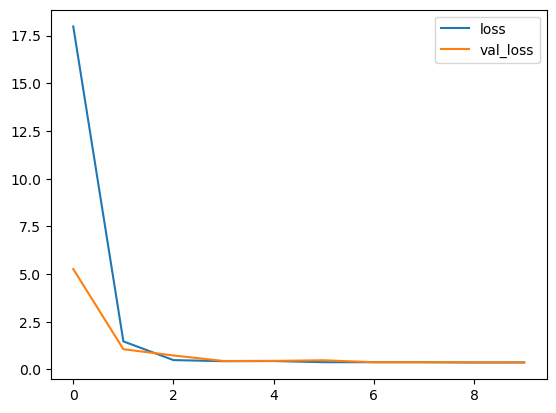

In [269]:
plt.plot(model_history.history['loss'],label='loss')
plt.plot(model_history.history['val_loss'],label='val_loss')
plt.legend()
plt.show()

### Accuracy

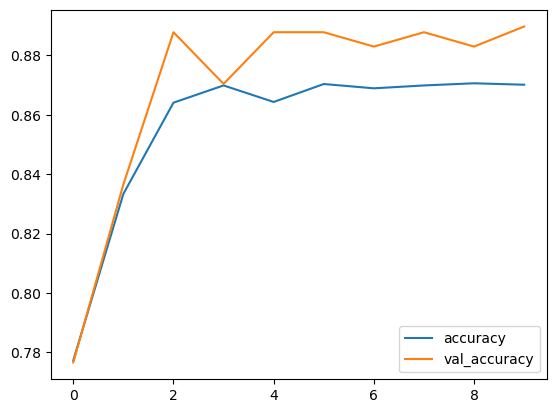

In [270]:
plt.plot(model_history.history['accuracy'],label='accuracy')
plt.plot(model_history.history['val_accuracy'],label='val_accuracy')
plt.legend()
plt.show()

In [271]:
prediction=ann.predict(ps_data)

162/162 [==============================] - 0s 1ms/step


In [272]:
threshold_value = 0.5

In [273]:
prediction_summary = (prediction > threshold_value).astype(int)

In [274]:
concatenated_array = np.concatenate((target.reshape(len(target), 1), prediction_summary.reshape(len(prediction_summary), 1)), 1)

In [275]:
np.set_printoptions(threshold=np.inf)

In [276]:
concatenated_array

array([[0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [1, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [0, 0],
       [1, 0],
       [0,

In [277]:
common_words = FreqDist(word_list).most_common(50)

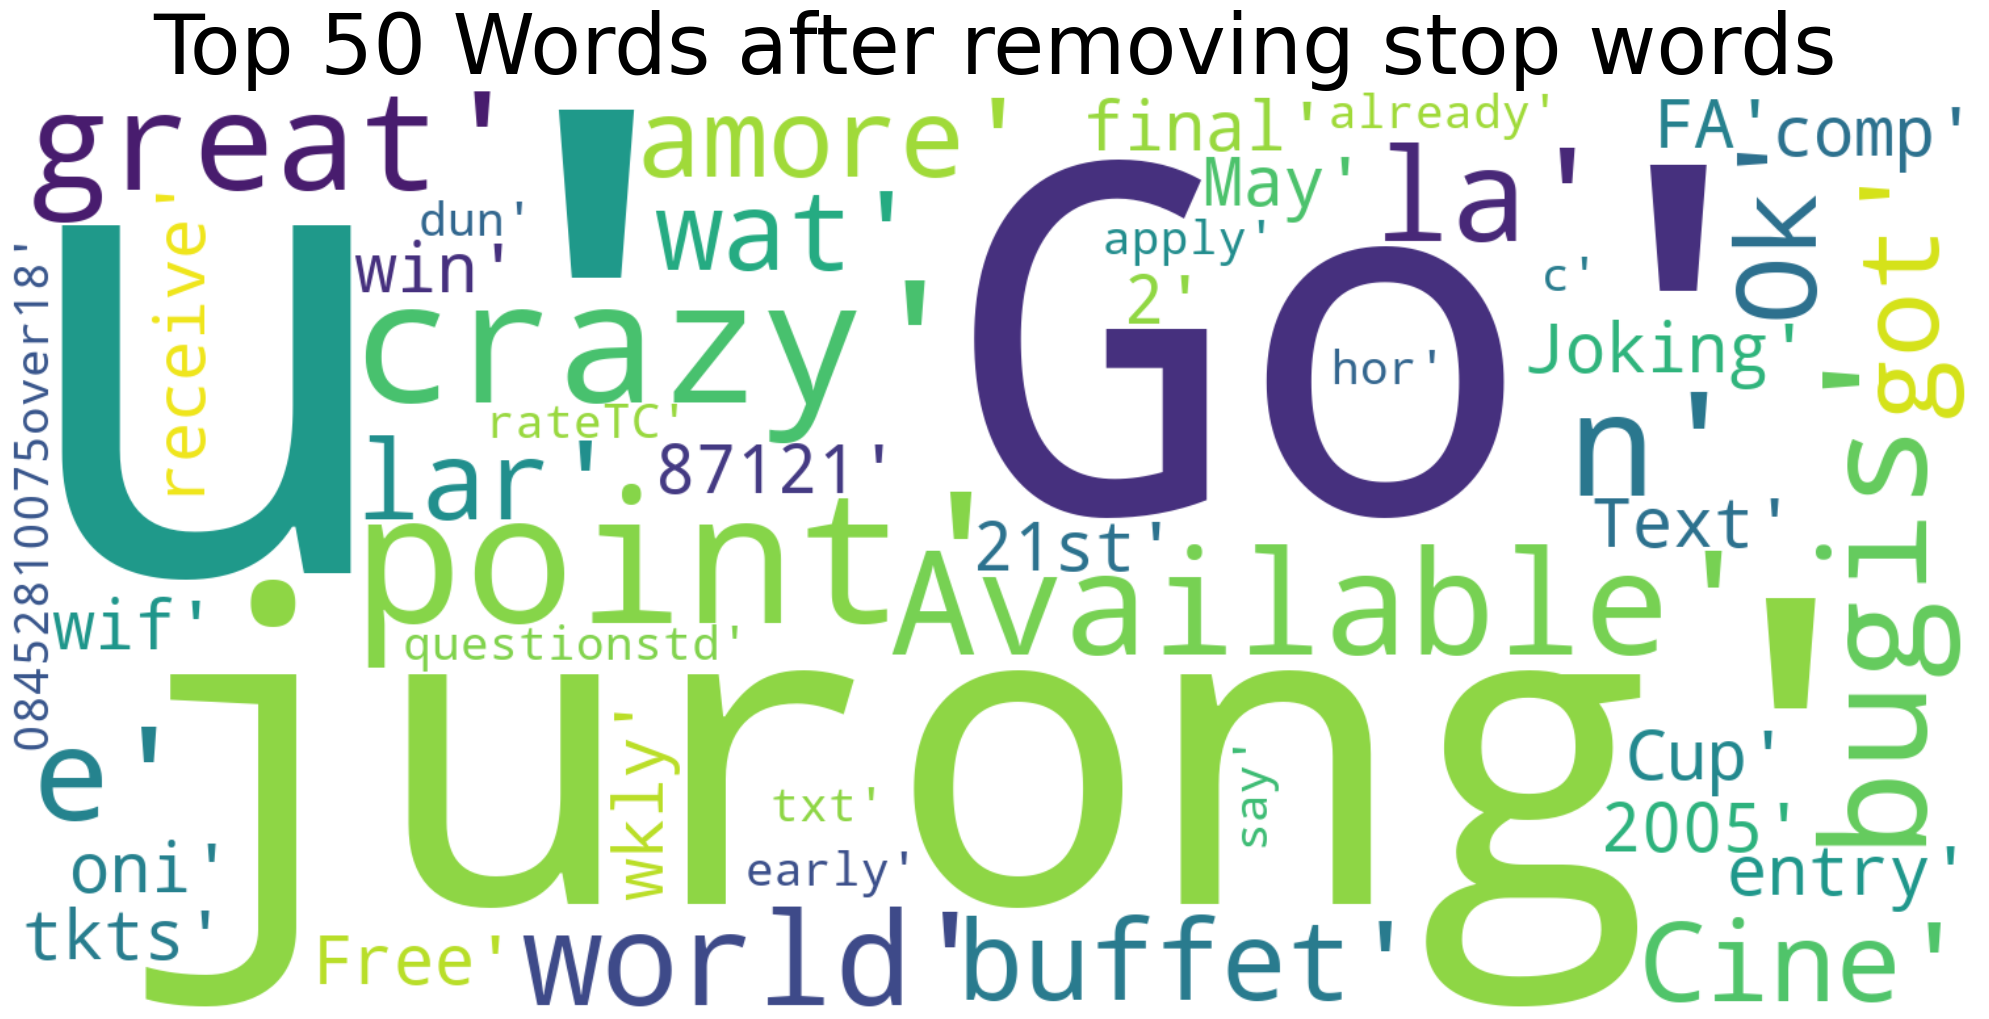

In [278]:

wordcloud = WordCloud(width=1500, height=700, background_color='white').generate(str(common_words))
fig = plt.figure(figsize=(40,10), facecolor='white')
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.title('Top 50 Words after removing stop words', fontsize=60)
plt.tight_layout(pad=0)
plt.show()


## Performance Metrics

In [279]:
from keras.metrics import Precision, Recall ,Accuracy
from sklearn.metrics import mean_squared_error
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.metrics import roc_auc_score

In [280]:
#AUC Score
roc =roc_auc_score(target,prediction)
print("ROC_AUC_SCORE:", roc)

ROC_AUC_SCORE: 0.6680884166150098


In [281]:
#Root Mean Squared Error
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse = sqrt(mean_squared_error(target, prediction_summary))
print("RMSE:", rmse)

RMSE: 0.3537927053945634


In [282]:
#Mean Squared Error
mse = mean_squared_error(target, prediction_summary)
print("MSE:", mse)

MSE: 0.12516927839040434


In [283]:
# Create Precision and Recall metrics
precision = Precision()
recall = Recall()
accuracy = Accuracy()

precision.update_state(target, prediction_summary)
recall.update_state(target, prediction_summary)
accuracy .update_state(target, prediction_summary)


precision_result = precision.result().numpy()
recall_result = recall.result().numpy()
accuracy_result = accuracy.result().numpy()


In [284]:
# display precision and recall values
print(f"Precision: {precision_result}")
print(f"Recall: {recall_result}")
print(f"Accuracy: {accuracy_result}")

Precision: 0.7142857313156128
Recall: 0.015313935466110706
Accuracy: 0.8748307228088379


In [285]:
print(classification_report(target, prediction_summary))

              precision    recall  f1-score   support

           0       0.88      1.00      0.93      4516
           1       0.71      0.02      0.03       653

    accuracy                           0.87      5169
   macro avg       0.79      0.51      0.48      5169
weighted avg       0.85      0.87      0.82      5169



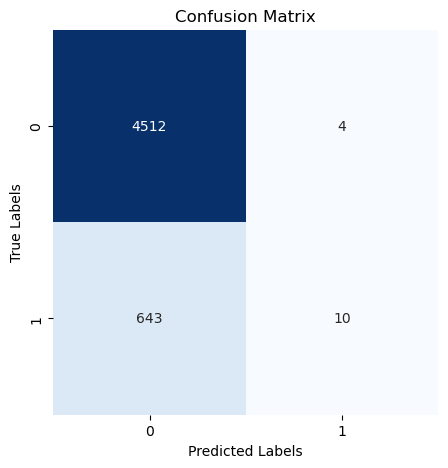

In [286]:
cm = confusion_matrix(target, prediction_summary)

# Visualize the confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False, square=True)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()